Connected to myenv (Python 3.9.19)

c:\Users\weijiexia\AppData\Local\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
epoch 49, loss: 0.0663: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


training complete


Running evaluation: 100%|██████████| 2589/2589 [00:15<00:00, 169.24it/s]

{
    "MSE": 180327.3567042251,
    "abs_error": 3439676.230886221,
    "abs_target_sum": 47040848.497024536,
    "abs_target_mean": 757.0627091706021,
    "seasonal_error": 49.52240499516449,
    "MASE": Infinity,
    "MAPE": 0.2809801271393499,
    "sMAPE": 0.12833915175914426,
    "MSIS": Infinity,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.1]": 1993166.1771577715,
    "Coverage[0.1]": 0.08563473670657912,
    "QuantileLoss[0.5]": 3439676.232259188,
    "Coverage[0.5]": 0.519441225698468,
    "QuantileLoss[0.9]": 1917130.8121294496,
    "Coverage[0.9]": 0.9198854126432342,
    "RMSE": 424.6496870412424,
    "NRMSE": 0.5609174535970292,
    "ND": 0.07312104991269003,
    "wQuantileLoss[0.1]": 0.04237096567856009,
    "wQuantileLoss[0.5]": 0.07312104994187672,
    "wQuantileLoss[0.9]": 0.040754596768183576,
    "mean_absolute_QuantileLoss": 2449991.073848803,
    "mean_wQuantileLoss": 0.05208220412954013,
    "MAE_Coverage": 0.41988541264323426,
    "OWA": NaN
}
   item_


c:\Users\weijiexia\AppData\Local\anaconda3\envs\myenv\lib\site-packages\pandas\core\dtypes\astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


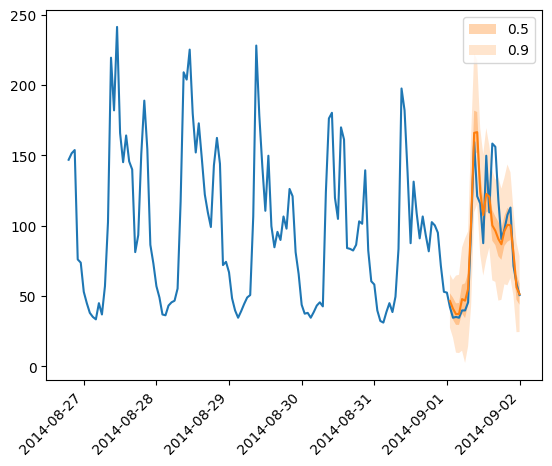

In [1]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
import matplotlib.pyplot as plt
import matplotlib as mpl
import json

from dataset.example import get_example_dataset
import model
from model.example import ExampleEstimator, ExampleTrainer
from utility.configuration import ExampleDataConfig, ExampleModelConfig, ExperimentConfig

def main():
    data_config = ExampleDataConfig.from_yaml(
        'configs/data/example.yaml'
    )
    model_config = ExampleModelConfig.from_yaml(
        'configs/model/example.yaml'
    )
    exp_config = ExperimentConfig(
        exp_id='0.0.666',
        data=data_config,
        model=model_config,
    )
    dataset = get_example_dataset(data_config)
    trainer = ExampleTrainer(lr=0.0001, epochs=50)
    estimator = ExampleEstimator(
        prediction_length=model_config.prediction_length, # TODO: should be in the data config
        past_length=model_config.past_length,
        hidden_dim=model_config.hidden_dim,
        forecast_type=model.ForecastType.STUDENTT,
        trainer=trainer,
    )
    estimator.create_training_network()
    predictor = estimator.train(dataset)
    
    # Evaluation
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,
        predictor=predictor,
        num_samples=100,
    )
    ts_entry = next(iter(ts_it))
    forecast_entry = next(iter(forecast_it))
    plt.plot(ts_entry[-150:].to_timestamp())
    forecast_entry.plot(show_label=True)
    plt.setp(plt.gca().get_xticklabels(), rotation=45, ha='right')
    plt.legend()
    pass
    
    if estimator.forecast_type == model.ForecastType.POINT:
        evaluator = Evaluator(quantiles=['0.5']) # which quantiles to evaluate NEED to match the model specification. 
    else:
        evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(
        iter(ts_it),
        iter(forecast_it),
        num_series=len(dataset.test)-1,
    )
    print(json.dumps(agg_metrics, indent=4))
    print(item_metrics.head())
    pass

if __name__ == "__main__":
    main()